In this notebook, we're going to process the data a little more. Specifically, we want to do the following:
1. Process the metadata a little more extracting more features from the gut sections; 
2. Incorporate results from the feature based molecular network analysis, assigning metabolites networks as unique features;
3. Make a version of our metabolite abundances that shows simple presence/absence. We will explain our reasoning behind this below.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
metadata = pd.read_csv("../cleaning/metadata_clean.csv", index_col=0)
raw_data = pd.read_csv("../cleaning/data_clean.csv", index_col=0)

In [3]:
metadata.head()

,organism,pool,time_point,gut_section,infection_status
1,T.cruzi_tryp,c1,0,AM,Con
2,T.cruzi_tryp,c1,0,PM,Con
3,T.cruzi_tryp,c1,0,H,Con
4,T.cruzi_tryp,c2,0,AM,Con
5,T.cruzi_tryp,c2,0,PM,Con


## Processing metadata
We can drop the pool column. This simply referes to the fact that we have biological triplicates. For the purposes of determining if an insect is infected, this is irrelevant.

Further to this, let's switch all "Starved" in the infection_status column to "Con" (control) since they're uninfected. Additionally, we can convert this column to 0 for control and 1 for infected.

In [4]:
metadata = metadata.drop("pool", axis=1)

In [5]:
metadata["infection_status"] = metadata["infection_status"].replace("Starved", 0)
metadata["infection_status"] = metadata["infection_status"].replace("Con", 0)
metadata["infection_status"] = metadata["infection_status"].replace("Inf", 1)
metadata.head()

,organism,time_point,gut_section,infection_status
1,T.cruzi_tryp,0,AM,0
2,T.cruzi_tryp,0,PM,0
3,T.cruzi_tryp,0,H,0
4,T.cruzi_tryp,0,AM,0
5,T.cruzi_tryp,0,PM,0


Now we can expand the "gut_section" column based on the section of gut: anterior midgut (AM), posterior midgut (PM) or hindgut (H).

We can do something similar for the different organism.

In [6]:
metadata = pd.get_dummies(metadata, columns=["gut_section","organism"])

In [7]:
columns_update = {'organism_R.prolixus_starved': 'R.prolixus_starved', 'organism_T.cruzi_epi':'T.cruzi_epi',
       'organism_T.cruzi_tryp':'T.cruzi_tryp'}
metadata = metadata.rename(columns=columns_update)
metadata.head()

,time_point,infection_status,gut_section_AM,gut_section_H,gut_section_PM,R.prolixus_starved,T.cruzi_epi,T.cruzi_tryp
1,0,0,1,0,0,0,0,1
2,0,0,0,0,1,0,0,1
3,0,0,0,1,0,0,0,1
4,0,0,1,0,0,0,0,1
5,0,0,0,0,1,0,0,1


## Convert to presence/absence data
As we will see below, the metabolite abundance is spread over several logs of magnitude. This has to do with the collection of the data. Some compounds ionise better than others and so will give a higher signal. This can give the false impression that a given compound is more abundant than any other compound when in fact it could just be related to the level at which it ionises. Although we can compare the same compound between samples by making the assumption a compound ionises equally well all the time, it's difficult to compare within different compounds within a single sample. So as not to skew the importance based on this, we are going to classify compounds as simply being present (1) or not (0). Then we can move on to testing some models to simply answer the question of is *the presence* of a metabolite important for determining infection status?"

In [8]:
raw_data.head()
        

,0,1,2,3,4,5,6,7,8,9,...,1426,1427,1428,1429,1430,1431,1432,1433,1434,1435
1,0.0,3.312179e+06,0.000000,172865.362833,0.0,0.0,0.0,1.171776e+06,2.345421e+06,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,4.778688e+06,487642.148167,881565.153833,0.0,0.0,0.0,1.845586e+06,2.738662e+06,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,7.474432e+06,0.000000,0.000000,0.0,0.0,0.0,1.247987e+06,1.435181e+06,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101,0.0,7.369074e+06,0.000000,0.000000,0.0,0.0,0.0,3.643449e+05,3.491248e+05,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,0.0,7.336385e+06,0.000000,0.000000,0.0,0.0,0.0,7.175403e+05,5.038600e+05,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
data = raw_data.apply(lambda x: [1 if y > 0 else 0 for y in x])

data.head(15)

,0,1,2,3,4,5,6,7,8,9,...,1426,1427,1428,1429,1430,1431,1432,1433,1434,1435
1,0,1,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
10,0,1,1,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
100,0,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
101,0,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
102,0,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
103,0,1,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
104,0,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
105,1,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
106,0,0,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
107,1,0,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
data.to_csv("pres_abs.csv")

## Feature engineering

At the moment, our metabolite table includes all detected compounds. However, in reality some of these compounds are going to be structurally related. Our mass spectrometry data is actually MS/MS, which means that all of the major compounds that were detected were then fragmented and the sizes of these collected as well. An analogy might be that we collect the whole puzzle first and then we can break the puzzle apart and see how many pieces there are that make up the whole thing. Based on the composition of these fragments, we can determine if the compounds are likely to be related or not.

To that end, we performed feature based molecular networking ([results here](https://gnps.ucsd.edu/ProteoSAFe/status.jsp?task=5a6231ed03724b088fa0055e33397038)) with the network shown below. These clusters all have an ID and so we can now import these as unique features a given sample that contains any given compound.

<img src=attachment:Screenshot.png alt="Drawing" style="width: 600px;"/> 

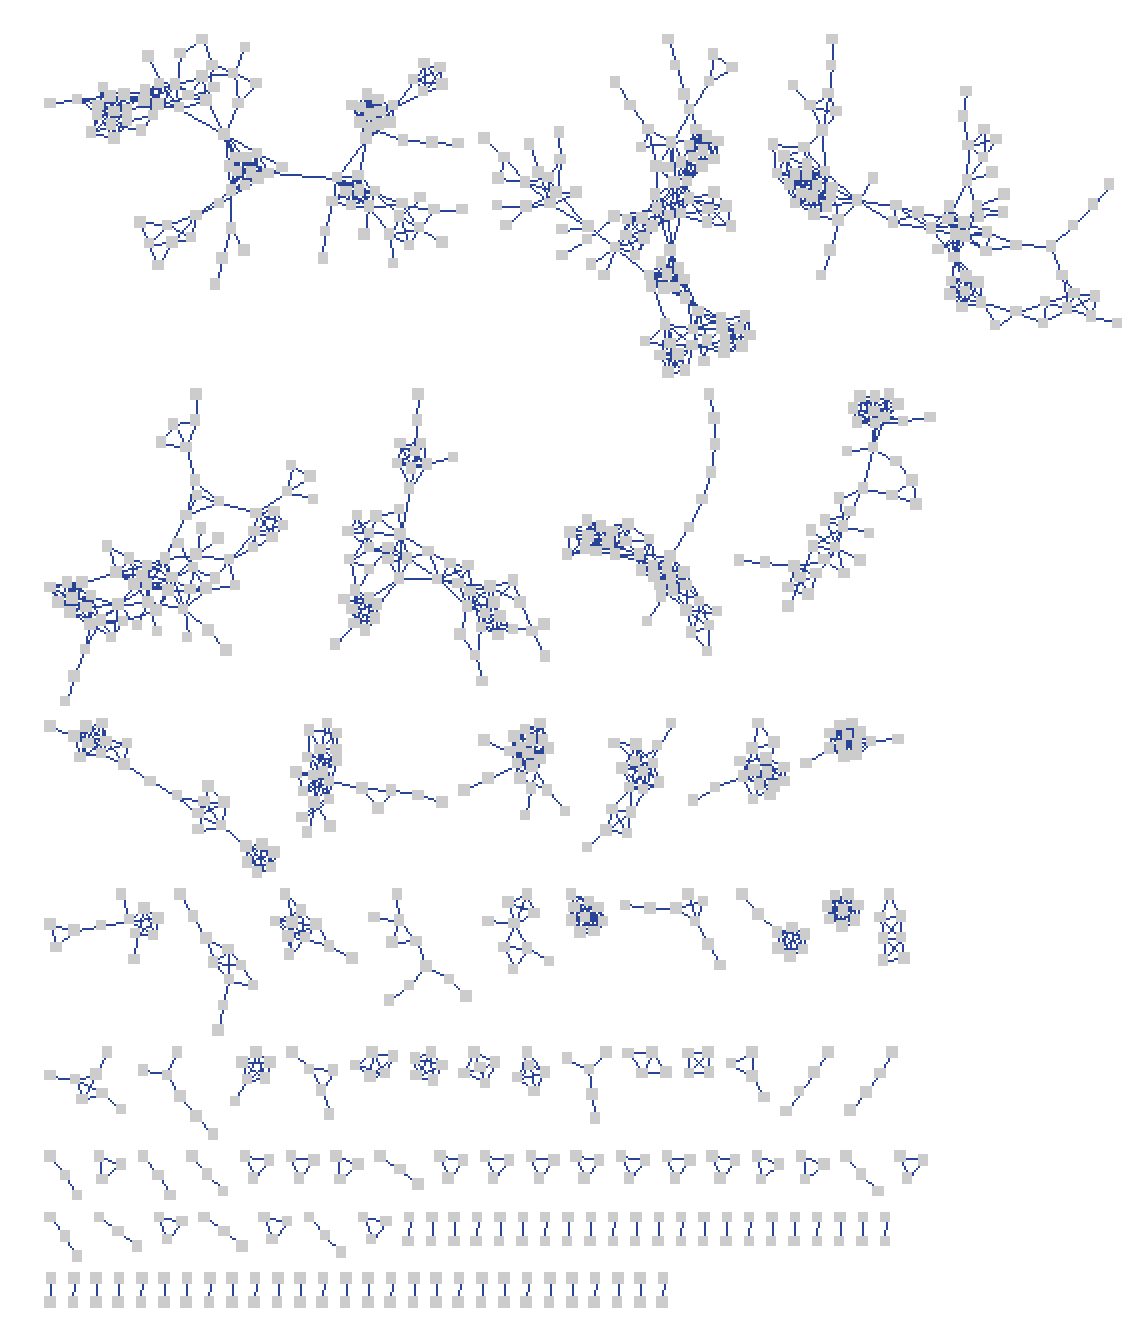

In [11]:
#import network data
network_data = pd.read_csv("../data/Network_nodes.csv")
network_data.head()

,Adduct,AllGroups,Analog:Adduct,Analog:Compound_Name,Analog:Compound_Source,Analog:Data_Collector,Analog:GNPSLibraryURL,Analog:INCHI,Analog:Instrument,Analog:Ion_Source,...,precursor mass,RTConsensus,RTMean,selected,shared name,SharedPeaks,Smiles,SpectrumID,sum(precursor intensity),UniqueFileSources
0,NaN,NaN,M+H,PC(0:0/18:0); [M+H]+ C26H55N1O7P1,Commercial,Thomas Metz,http://gnps.ucsd.edu/ProteoSAFe/gnpslibraryspe...,NaN,CID; Velos,LC-ESI,...,475.8019,12.7918,12.7918,False,4021,NaN,NaN,NaN,1.010260e+06,NaN
1,[M+Na]+,NaN,[M+Na]+,OUABAIN,isolated,MoNA:VF-NPL-QEHF015046,http://gnps.ucsd.edu/ProteoSAFe/gnpslibraryspe...,InChI=1S/C29H44O12/c1-13-22(34)23(35)24(36)25(...,ESI-QFT,NaN,...,607.3900,16.7180,16.7180,False,184,8.0,NaN,CCMSLIB00004706109,1.114359e+08,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,682.5968,19.7050,19.7050,False,13873,NaN,NaN,NaN,5.351705e+06,NaN
3,M+H,NaN,M+H,"Spectral Match to 1,2-Dipentadecanoyl-sn-glyce...",Isolated,Data deposited by negarg,http://gnps.ucsd.edu/ProteoSAFe/gnpslibraryspe...,NaN,HCD,ESI,...,608.3900,11.6533,11.6533,False,6267,7.0,NaN,CCMSLIB00003136467,6.648658e+05,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,692.5154,17.2878,17.2878,False,4593,NaN,NaN,NaN,6.243137e+06,NaN


Our target column here for cluster identification is "componentindex", which can be matched to our peak_IDs file via "name" == "row ID".

In [12]:
peaks = pd.read_csv("../cleaning/peak_IDs.csv")
peaks.head()

,row ID,m/z,retention time
0,12.0,415.210919,9.200066
1,14.0,437.192936,9.200345
2,16.0,457.276727,10.471969
3,19.0,327.177550,8.663874
4,22.0,553.255367,12.873119


In [13]:
peaks.shape

(1436, 3)

In [14]:
#for consistency, we rename row ID
peaks = peaks.rename(columns={"row ID":"name"})

In [15]:
#take our desired columns
Network_id = network_data[["name", "componentindex"]]

In [16]:
Network_id

,name,componentindex
0,4021,45
1,184,11
2,13873,6
3,6267,246
4,4593,6
...,...,...
903,6625,16
904,47,2
905,202,200
906,7831,24


908 metabolites are part of a network of 2 or more

In [17]:
peaks_update = peaks.join(Network_id.set_index("name"), how='left', on="name")

In [18]:
peaks_update.head(10)

,name,m/z,retention time,componentindex
0,12.0,415.210919,9.200066,2.0
1,14.0,437.192936,9.200345,2.0
2,16.0,457.276727,10.471969,36.0
3,19.0,327.177550,8.663874,NaN
4,22.0,553.255367,12.873119,2.0
5,23.0,119.085962,9.200257,NaN
6,25.0,629.371696,16.715573,1.0
7,26.0,480.307750,10.962874,7.0
8,28.0,522.354513,10.996964,32.0
9,31.0,763.515364,16.248348,7.0


In [19]:
print(sum(peaks_update["componentindex"].isna()))

528


Quick sanity check: number of na values plus number of metabolites in networks (908) should equal 1436. It does.

In [20]:
peaks_update = peaks_update.T
peaks_update

,0,1,2,3,4,5,6,7,8,9,...,1426,1427,1428,1429,1430,1431,1432,1433,1434,1435
name,12.000000,14.000000,16.000000,19.000000,22.000000,23.000000,25.000000,26.000000,28.000000,31.000000,...,18911.000000,19007.000000,19127.000000,19207.000000,19454.000000,19466.000000,19548.000000,19869.000000,19994.000000,20163.000000
m/z,415.210919,437.192936,457.276727,327.177550,553.255367,119.085962,629.371696,480.307750,522.354513,763.515364,...,124.967214,453.167010,443.171244,309.581772,616.175797,224.091635,725.615763,522.354360,417.025757,309.098409
retention time,9.200066,9.200345,10.471969,8.663874,12.873119,9.200257,16.715573,10.962874,10.996964,16.248348,...,0.314417,9.316367,9.338894,9.070340,9.046608,2.965430,12.324333,11.067387,4.857672,9.662856
componentindex,2.000000,2.000000,36.000000,NaN,2.000000,NaN,1.000000,7.000000,32.000000,7.000000,...,NaN,NaN,122.000000,112.000000,10.000000,101.000000,NaN,32.000000,NaN,NaN


In [21]:
peaks_update.to_csv('peaks_updated.csv')

This was modified in excel so that every sample that had a metabolite in a given network was counted in a new column (one for each network component index). We reimport this now. 

In [22]:
network_table = pd.read_csv("network_table.csv", index_col=[0], sep=";")
network_table.head()

,0,1,2,3,4,5,6,7,8,9,...,componentindex_202.0,componentindex_205.0,componentindex_208.0,componentindex_211.0,componentindex_220.0,componentindex_228.0,componentindex_238.0,componentindex_246.0,componentindex_249.0,componentindex_251.0
1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,2.0,0.0,1.0,0.0,1.0
10.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
100.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
101.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
102.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Let's make everything with a count higher than 1 to equal 1, consistent with what we have so far.  

In [23]:
network_table = network_table.apply(lambda x: [1 if y > 0 else 0 for y in x])
network_table.head()

,0,1,2,3,4,5,6,7,8,9,...,componentindex_202.0,componentindex_205.0,componentindex_208.0,componentindex_211.0,componentindex_220.0,componentindex_228.0,componentindex_238.0,componentindex_246.0,componentindex_249.0,componentindex_251.0
1.0,0,1,0,1,0,0,0,1,1,0,...,0,1,0,1,1,1,0,1,0,1
10.0,0,1,1,1,0,0,0,1,1,0,...,0,1,0,1,0,0,0,1,0,0
100.0,0,1,0,0,0,0,0,1,1,0,...,0,0,0,1,0,0,1,0,0,0
101.0,0,1,0,0,0,0,0,1,1,0,...,0,0,0,1,0,0,0,0,0,1
102.0,0,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1


One last thing to do is drop all columns that are present in less than 10% of samples (~17) since they're unlikely to contribute meaningfully to our models, but may contribute to over-fitting.

In [24]:
nothing_int = [col for col in network_table.columns if network_table[col].astype(bool).sum(axis=0) == 0]
print(nothing_int)
print(len(nothing_int))

network_table.shape

['15', '31', '32', '33', '48', '94', '97', '107', '120', '121', '144', '155', '158', '223', '277', '278', '282', '372', '373', '374', '378', '389', '391', '402', '422', '424', '552', '561', '771', '951', '1161', '1261', '1262', '1341', '1342', '1432']
36


(173, 1549)

In [25]:
network_table = network_table.drop(nothing_int, axis=1) 

near_zero = [col for col in network_table.columns if network_table[col].astype(bool).sum(axis=0) <= 17]
print(near_zero)
print(len(near_zero))

['4', '17', '23', '26', '30', '41', '42', '43', '52', '57', '58', '64', '65', '72', '76', '95', '98', '103', '105', '106', '108', '109', '113', '114', '125', '127', '128', '135', '140', '145', '149', '152', '162', '163', '168', '169', '172', '180', '184', '188', '190', '196', '197', '206', '210', '213', '215', '216', '225', '229', '232', '240', '241', '242', '244', '248', '250', '253', '256', '258', '268', '271', '276', '284', '286', '287', '288', '289', '290', '291', '293', '294', '295', '296', '297', '298', '301', '302', '303', '304', '305', '306', '308', '309', '313', '317', '318', '319', '325', '326', '327', '353', '360', '369', '370', '398', '417', '434', '436', '439', '444', '469', '471', '476', '488', '503', '506', '507', '508', '511', '512', '515', '518', '520', '521', '522', '523', '524', '525', '529', '530', '531', '532', '533', '544', '546', '547', '557', '560', '562', '566', '572', '574', '575', '577', '578', '584', '585', '586', '589', '590', '591', '592', '597', '599', '6

In [26]:
network_table = network_table.drop(near_zero, axis=1)
network_table.shape

(173, 924)

We've now dropped 36+589 columns that either had no relevance because those metabolites weren't detectable above background or removed because they were present in less than 10% of samples.

## Merge the metadata

In [27]:
merged_data = network_table.join(metadata, how='inner')
merged_data

,0,1,2,3,5,6,7,8,9,10,...,componentindex_246.0,componentindex_251.0,time_point,infection_status,gut_section_AM,gut_section_H,gut_section_PM,R.prolixus_starved,T.cruzi_epi,T.cruzi_tryp
1.0,0,1,0,1,0,0,1,1,0,0,...,1,1,0,0,1,0,0,0,0,1
2.0,0,1,1,1,0,0,1,1,0,0,...,0,1,0,0,0,0,1,0,0,1
3.0,0,1,1,1,0,0,1,1,0,0,...,0,1,0,0,0,1,0,0,0,1
4.0,0,1,1,1,0,0,1,1,0,0,...,1,1,0,0,1,0,0,0,0,1
5.0,0,1,1,1,0,0,1,1,1,1,...,0,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173.0,1,0,1,1,1,0,1,1,0,0,...,0,0,4,0,0,0,1,0,1,0
174.0,1,0,1,1,1,1,1,0,0,0,...,0,0,4,0,0,1,0,0,1,0
175.0,1,1,1,1,1,0,1,1,1,0,...,1,0,4,0,1,0,0,0,1,0
176.0,1,1,1,1,1,0,1,1,0,0,...,0,0,4,0,0,0,1,0,1,0


We can see that we've added the 8 columns from earlier and still have our 171 samples. We can save this and start training some models.

In [28]:
merged_data.to_csv('merged_data.csv')